In [1]:
# Author: Guoqing Bao
# School of Computer Science, The University of Sydney
# Date: 2019-12-12
# GitHub Project Link: https://github.com/guoqingbao/Pathofusion
# Please cite our work if you found it is useful for your research or clinical practice

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
gc.enable()
import warnings;
warnings.filterwarnings('ignore');
import tensorflow as tf
import sqlite3
%matplotlib inline 
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_fscore_support
# from sklearn import cross_validation, metrics
from sklearn.metrics import f1_score,confusion_matrix, classification_report, accuracy_score


import torch.optim as optim
import torch.backends.cudnn as cudnn
from tqdm import tqdm

# config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
# config.gpu_options.allow_growth=True
from io import StringIO

# import helper function (database manupulation, image augmentation, plot performance, train, etc.)
from project.models.helper import *

# import our BCNN from models
from project.models.bcnn import BCNN

Using TensorFlow backend.


In [2]:
project_path = './project/brain/'
path = project_path + "results/bcnn/"

conn_256 = create_or_open_db(project_path + "data/cd276_labeling_256.db")
conn_512 = create_or_open_db(project_path + "data/cd276_labeling_512.db")

Schema exists

Schema exists



In [3]:
# for ihc images, "load_data" convert type to positive (type>0) and negative expression (type==0)
x_train, y_train, x_test, y_test = load_data(project_path + "data/cd276_labeling_256.db", test_ids=test_patient_ids, ihc=True) # patch ID and type
trainLoader = DataGenerator(x_train, y_train, connections=[conn_256, conn_512], image_sizes=[256,512], augment=True, classes=2)
testLoader = DataGenerator(x_test, y_test, connections=[conn_256, conn_512], image_sizes=[256,512], augment=False, classes=2)

Schema exists



In [4]:
model = BCNN(2, False)
print('Number of model parameters: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))

Number of model parameters: 11617250


In [5]:
# load the model if we have trained
if os.path.exists(path + 'torch_model_cd276.h5'):
    checkPoint = torch.load(path + 'torch_model_cd276.h5')
    model.load_state_dict(checkPoint)
    model = nn.DataParallel(model).cuda()

In [6]:
# otherwise, train the model and save (we only save the last epoch model)
if not os.path.exists(path + 'torch_model_cd276.h5'):
    history = train(model, trainLoader, testLoader, multiinputs=True, epochs=50, base_lr=0.0001, weight_decay=0.005, log_path=path, log_file='cd276_train_test.log')
    torch.save(model.state_dict(), path + 'torch_model_cd276.h5')
    np.save(path + 'train_test_history_cd276.npy', np.array(history.history))

Epoch	LearningRate	TrainLoss	TestLoss	TrainAcc.	TestAcc.	EndTime.


  0%|          | 0/229 [00:00<?, ?it/s]

1	0.000100	1.192758	0.328818	74.688740	86.657816	12/12 13:22:14


  0%|          | 0/229 [00:00<?, ?it/s]                                         

2	0.000100	0.491923	0.266588	93.405391	88.184534	12/12 13:24:58


  0%|          | 0/229 [00:00<?, ?it/s]                                         

3	0.000100	0.361257	0.233271	94.910384	88.981082	12/12 13:27:46


  0%|          | 0/229 [00:00<?, ?it/s]                                         

4	0.000099	0.297302	0.167680	95.758654	93.528045	12/12 13:30:32


  0%|          | 0/229 [00:00<?, ?it/s]                                         

5	0.000098	0.266843	0.148342	96.100698	94.623299	12/12 13:33:18


  0%|          | 0/229 [00:00<?, ?it/s]                                         

6	0.000098	0.238225	0.215702	96.620605	90.640558	12/12 13:36:05


  0%|          | 0/229 [00:00<?, ?it/s]                                         

7	0.000096	0.221604	0.186685	96.894240	91.968138	12/12 13:38:53


  0%|          | 0/229 [00:00<?, ?it/s]                                         

8	0.000095	0.217973	0.164411	96.825831	93.162961	12/12 13:41:41


  0%|          | 0/229 [00:00<?, ?it/s]                                         

9	0.000094	0.206384	0.143700	97.058421	94.590110	12/12 13:44:27


  0%|          | 0/229 [00:00<?, ?it/s]                                         

10	0.000092	0.198837	0.111099	97.126830	96.116827	12/12 13:47:14


  0%|          | 0/229 [00:00<?, ?it/s]                                         

11	0.000090	0.184839	0.198602	97.455192	91.868570	12/12 13:50:00


  0%|          | 0/229 [00:00<?, ?it/s]                                         

12	0.000089	0.185458	0.144088	97.291011	94.357783	12/12 13:52:48


  0%|          | 0/229 [00:00<?, ?it/s]                                         

13	0.000086	0.178487	0.113626	97.455192	95.851311	12/12 13:55:32


  0%|          | 0/229 [00:00<?, ?it/s]                                         

14	0.000084	0.167000	0.149619	97.633055	94.059077	12/12 13:58:19


  0%|          | 0/229 [00:00<?, ?it/s]                                         

15	0.000082	0.163311	0.124613	97.660419	95.253900	12/12 14:01:05


  0%|          | 0/229 [00:00<?, ?it/s]                                         

16	0.000079	0.149223	0.134215	97.783555	94.888815	12/12 14:03:51


  0%|          | 0/229 [00:00<?, ?it/s]                                         

17	0.000077	0.145669	0.151769	97.906690	94.092267	12/12 14:06:38


  0%|          | 0/229 [00:00<?, ?it/s]                                         

18	0.000074	0.141536	0.216078	97.947736	90.706937	12/12 14:09:15


  0%|          | 0/229 [00:00<?, ?it/s]                                         

19	0.000071	0.134081	0.118081	98.125599	95.784932	12/12 14:11:54


  0%|          | 0/229 [00:00<?, ?it/s]                                         

20	0.000068	0.136484	0.125252	97.975099	95.552605	12/12 14:14:32


  0%|          | 0/229 [00:00<?, ?it/s]                                         

21	0.000065	0.129545	0.125424	98.070872	95.253900	12/12 14:17:12


  0%|          | 0/229 [00:00<?, ?it/s]                                         

22	0.000062	0.121584	0.131932	98.344507	94.988384	12/12 14:19:52


  0%|          | 0/229 [00:00<?, ?it/s]                                         

23	0.000059	0.114767	0.115864	98.481324	95.287089	12/12 14:22:32


  0%|          | 0/229 [00:00<?, ?it/s]                                         

24	0.000056	0.111156	0.113925	98.426597	95.851311	12/12 14:25:12


  0%|          | 0/229 [00:00<?, ?it/s]                                         

25	0.000053	0.103096	0.277970	98.631824	87.786260	12/12 14:27:50


  0%|          | 0/229 [00:00<?, ?it/s]                                         

26	0.000050	0.103914	0.123870	98.631824	95.353468	12/12 14:30:32


  0%|          | 0/229 [00:00<?, ?it/s]                                         

27	0.000050	0.103259	0.113450	98.604460	95.818121	12/12 14:33:14


  0%|          | 0/229 [00:00<?, ?it/s]                                         

28	0.000050	0.096937	0.177739	98.713914	92.930634	12/12 14:35:56


  0%|          | 0/229 [00:00<?, ?it/s]                                         

29	0.000050	0.094611	0.378882	98.809687	82.841022	12/12 14:38:34


  0%|          | 0/229 [00:00<?, ?it/s]                                         

30	0.000050	0.094212	0.121967	98.631824	95.618984	12/12 14:41:19


  0%|          | 0/229 [00:00<?, ?it/s]                                         

31	0.000050	0.085838	0.115725	98.946504	95.751742	12/12 14:44:00


  0%|          | 0/229 [00:00<?, ?it/s]                                         

32	0.000050	0.078196	0.124715	99.001231	95.320279	12/12 14:46:43


  0%|          | 0/229 [00:00<?, ?it/s]                                         

33	0.000050	0.082813	0.166576	99.014913	93.295719	12/12 14:49:24


  0%|          | 0/229 [00:00<?, ?it/s]                                         

34	0.000050	0.086401	0.148472	99.014913	94.656489	12/12 14:52:05


  0%|          | 0/229 [00:00<?, ?it/s]                                         

35	0.000050	0.079511	0.139595	99.001231	94.722868	12/12 14:54:43


  0%|          | 0/229 [00:00<?, ?it/s]                                         

36	0.000050	0.075325	0.115899	99.028595	95.652174	12/12 14:57:19


  0%|          | 0/229 [00:00<?, ?it/s]                                         

37	0.000050	0.072472	0.124634	99.042277	95.220710	12/12 14:59:47


  0%|          | 0/229 [00:00<?, ?it/s]                                         

38	0.000050	0.072355	0.127653	99.179094	95.187521	12/12 15:02:14


  0%|          | 0/229 [00:00<?, ?it/s]                                         

39	0.000050	0.070343	0.117239	99.206458	95.851311	12/12 15:04:41


  0%|          | 0/229 [00:00<?, ?it/s]                                         

40	0.000050	0.069340	0.106796	99.247503	96.017259	12/12 15:07:08


  0%|          | 0/229 [00:00<?, ?it/s]                                         

41	0.000050	0.067800	0.113380	99.192776	95.984069	12/12 15:09:35


  0%|          | 0/229 [00:00<?, ?it/s]                                         

42	0.000050	0.070170	0.112900	99.233821	96.050448	12/12 15:12:03


  0%|          | 0/229 [00:00<?, ?it/s]                                         

43	0.000050	0.065437	0.113942	99.343275	96.150017	12/12 15:14:31


  0%|          | 0/229 [00:00<?, ?it/s]                                         

44	0.000050	0.066268	0.111628	99.261185	96.183206	12/12 15:16:58


  0%|          | 0/229 [00:00<?, ?it/s]                                         

45	0.000050	0.063682	0.119780	99.302230	95.818121	12/12 15:19:26


  0%|          | 0/229 [00:00<?, ?it/s]                                         

46	0.000050	0.062846	0.112238	99.411684	96.216396	12/12 15:21:54


  0%|          | 0/229 [00:00<?, ?it/s]                                         

47	0.000050	0.063911	0.115335	99.343275	96.050448	12/12 15:24:22


  0%|          | 0/229 [00:00<?, ?it/s]                                         

48	0.000050	0.064203	0.114232	99.356957	96.216396	12/12 15:26:51


  0%|          | 0/229 [00:00<?, ?it/s]                                         

49	0.000050	0.065531	0.114944	99.261185	96.083638	12/12 15:29:18


50	0.000050	0.060522	0.116470	99.480093	96.116827	12/12 15:31:46


In [7]:
history = np.load(path + 'train_test_history_cd276.npy',allow_pickle=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


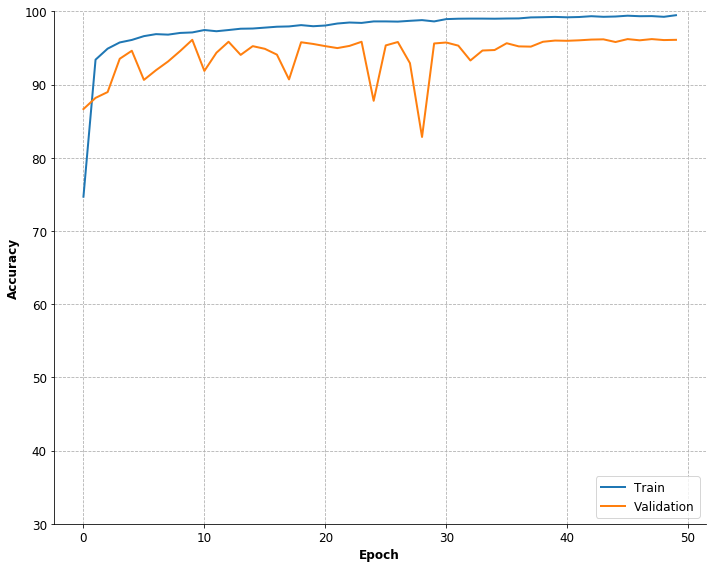

In [8]:
# let's plot the train/test history
trains, tests = show_train_history([history.item()], 'acc', 'val_acc', path, 'train_test_history_cd276')

In [6]:
#let's see the test results
model.eval()
probas_ = []
with torch.no_grad():
    for i in range(len(testLoader)):
        [x1, x2], t = testLoader[i]
        m1, m2, t = Variable(torch.FloatTensor(x1).cuda()), Variable(torch.FloatTensor(x2).cuda()), \
                        Variable(torch.LongTensor(t.tolist()).cuda())
        y = model(m1, m2)
        probas_.extend(F.softmax(y).cpu().numpy().tolist())
probas_ = np.array(probas_)
pred = np.argmax(probas_,axis=1) 
ac = accuracy_score(y_test, pred)
print("External Testing accuracy {}\r\n".format(ac))

External Testing accuracy 0.9611682708264189



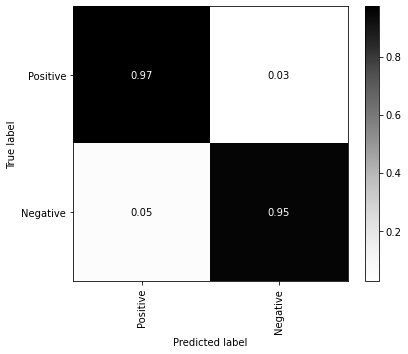

In [11]:
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical
fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(1,1,1)
classesnames = ['Positive', 'Negative']

cm = confusion_matrix(y_test, pred, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classesnames)
disp.plot(include_values=True,cmap='Greys', ax=ax1, xticks_rotation=90,values_format='.2f')


fig.tight_layout()
fig.savefig(path + 'confusion_matrix_cd276.svg',format='svg')

# confusion_matrix(to_categorical(y_test,num_classes=6,dtype='int32'), to_categorical(pred,num_classes=6,dtype='int32'))

In [10]:
# and other test metrics

precision_recall_fscore = []

prf = precision_recall_fscore_support(y_test, pred,average = "weighted")
ac = accuracy_score(y_test, pred)

precision_recall_fscore.append([prf[0],prf[1],prf[2],ac])

metrics = pd.DataFrame(np.array(precision_recall_fscore), columns=['precision','recall','f1-score','accuracy'])
mean_values = []
for i in range(4):
    mean_values.append(np.mean(np.array(precision_recall_fscore)[:,i]))
metrics = metrics.append(pd.Series(mean_values, index=metrics.columns, name="Average"))
metrics.to_excel(path + 'test_metrics_cd276.xlsx')
metrics

,precision,recall,f1-score,accuracy
0,0.962177,0.961168,0.961339,0.961168
Average,0.962177,0.961168,0.961339,0.961168


In [17]:
def roc_plot(n_classes_, y_tests_,y_prediction_proba_, path, filename ):
    # plt.rcParams['font.sans-serif']=['Arial']
    plt.rcParams['axes.unicode_minus']=False 
#     plt.grid(linestyle = "--")
    ax = plt.gca()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    fig = plt.gcf()
    fig.set_size_inches(5.5, 4.5)

    tprs_all = []
    aucs_all = []
    mean_fpr = np.linspace(0, 1, 100)

    auc_values = []
    classesnames = ['Positive', 'Negative']
    colors = ['red', 'cyan','green']
    for j in range(n_classes_):
        tprs = []
        aucs = []        
        for i in range(len(y_tests_)):
            fpr, tpr, thresholds = roc_curve(to_categorical(y_tests_[i],num_classes=n_classes_)[:, j], y_prediction_proba_[i][:, j])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs_all.append(interp(mean_fpr, fpr, tpr))

            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            aucs_all.append(roc_auc)


        if len(y_tests_)== 1:
            mean_tpr = tprs[0]
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            plt.plot(mean_fpr, mean_tpr, color=colors[j],
                     label=r'%d. %s - ROC (AUC=%0.3f)' % (j+1,classesnames[j], mean_auc), linestyle='--',
                     lw=1., alpha=1)
            auc_values.append(mean_auc)
            
        else:
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            plt.plot(mean_fpr, mean_tpr, color=colors[j],
                     label=r' %d. %s - Mean ROC (AUC=%0.3f$\pm$%0.3f)' % (j+1, classesnames[j], mean_auc, std_auc),linestyle='--',
                     lw=1., alpha=1)
            auc_values.append(mean_auc)

    mean_tpr = np.mean(tprs_all, axis=0)
    mean_tpr[0] = .0
    mean_tpr[-1] = 1.0
    
    if n_classes_ > 1:
        plt.plot(mean_fpr, mean_tpr, color=colors[-1],
                 label=r'Mean ROC (AUC=%0.3f$\pm$%0.3f)' % (np.mean(auc_values),  np.std(auc_values)),
                 lw=2, alpha=1)
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Chance', alpha=1)



    std_tpr = np.std(tprs_all, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([0., 1.0])
    plt.ylim([0., 1.0])

    plt.xlabel('False Positive Rate',fontsize=14)
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.legend(loc="lower right", fontsize=12)


    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.tight_layout()
    plt.savefig(path + filename + '.svg',format='svg')

    plt.show()
    return mean_tpr, auc_values

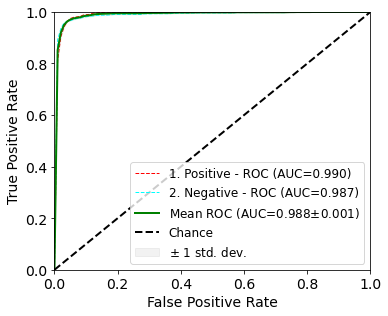

In [18]:
# the test roc/auc

yts=[]
yts.append(y_test)
pbs=[]
pbs.append(probas_)
mean_tpr, auc_values = roc_plot(2,yts,pbs, path,'roc_2class_test_cd276_conference')

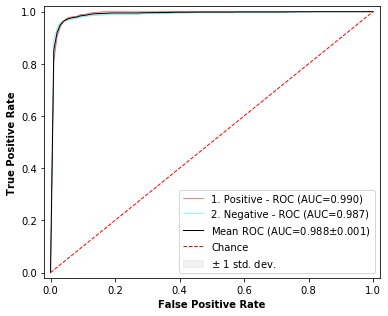

In [7]:
# the test roc/auc
classesnames = ['Positive', 'Negative']
colors = ['red', 'cyan','black']
yts=[]
yts.append(y_test)
pbs=[]
pbs.append(probas_)
mean_tpr, auc_values = roc_plot(2,yts,pbs, classesnames, colors, path,'roc_2class_test_cd276')

In [12]:
#save for later comparison
np.save(path + 'roc_2class_test_mean_tpr_cd276.npy',mean_tpr)
np.save(path + 'roc_2class_test_auc_values_cd276.npy',auc_values)

In [3]:
import numpy as np
np.mean(np.load(path + 'roc_2class_test_auc_values_cd276.npy'))

0.9882052380736424

# For Conference

In [9]:
classesnames = ['Positive', 'Negative']
def roc_plot(n_classes_, y_tests_,y_prediction_proba_, path, filename ):
    # plt.rcParams['font.sans-serif']=['Arial']
    plt.rcParams['axes.unicode_minus']=False 
#     plt.grid(linestyle = "--")
    ax = plt.gca()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    fig = plt.gcf()
    fig.set_size_inches(6, 5)

    tprs_all = []
    aucs_all = []
    mean_fpr = np.linspace(0, 1, 100)

    auc_values = []
    colors = ['red', 'cyan','yellow','lightgrey','green','green']
    for j in range(n_classes_):
        tprs = []
        aucs = []        
        for i in range(len(y_tests_)):
            fpr, tpr, thresholds = roc_curve(to_categorical(y_tests_[i],num_classes=n_classes_)[:, j], y_prediction_proba_[i][:, j])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs_all.append(interp(mean_fpr, fpr, tpr))

            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            aucs_all.append(roc_auc)


        if len(y_tests_)== 1:
            mean_tpr = tprs[0]
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            plt.plot(mean_fpr, mean_tpr, color=colors[j],
                     label=r'%d. %s - ROC (AUC=%0.3f)' % (j+1,classesnames[j], mean_auc), linestyle='--',
                     lw=1., alpha=1)
            auc_values.append(mean_auc)
            
        else:
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            plt.plot(mean_fpr, mean_tpr, color=colors[j],
                     label=r' %d. %s - Mean ROC (AUC=%0.3f$\pm$%0.3f)' % (j+1, classesnames[j], mean_auc, std_auc),linestyle='--',
                     lw=1., alpha=1)
            auc_values.append(mean_auc)

    mean_tpr = np.mean(tprs_all, axis=0)
    mean_tpr[0] = .0
    mean_tpr[-1] = 1.0
    
    if n_classes_ > 1:
        plt.plot(mean_fpr, mean_tpr, color=colors[-1],
                 label=r'Mean ROC (AUC=%0.3f$\pm$%0.3f)' % (np.mean(auc_values),  np.std(auc_values)),
                 lw=2, alpha=1)
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Chance', alpha=1)



    std_tpr = np.std(tprs_all, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([0., 1.0])
    plt.ylim([0., 1.0])

    plt.xlabel('False Positive Rate',fontsize=10)
    plt.ylabel('True Positive Rate',fontsize=10)
    plt.legend(loc="lower right")


    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(path + filename + '.svg',format='svg')

    plt.show()
    return mean_tpr, auc_values

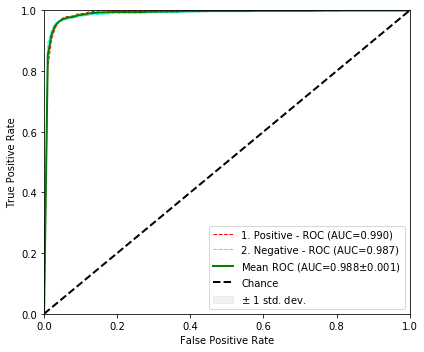

In [10]:
yts=[]
yts.append(y_test)
pbs=[]
pbs.append(probas_)
mean_tpr, auc_values = roc_plot(2,yts,pbs, path, 'roc_2class_test_cd276_conference')